# Extraction Methods using PyVista

This notebook demonstrates how PyVista can be used to perform various extraction methods.

In [1]:
import pyvista as pv
import numpy as np

We start but loading in an example unstructured mesh with synthetic data.

In [2]:
fname = '../data/pdata_C48_synthetic.vtk'
mesh = pv.read(fname)

We will be being extract data between latitude = [60$^{\circ}$N, 90$^{\circ}$N]

In [3]:
lo, hi = 60, 90

### "enclose" 
This method only selects cells that are completely enclosed within the extraction region.

In [4]:
# Determine the latitude values of all the nodes and add these `rlats` as an attribute to the mesh.
radius = 1.0
rlo, rhi = radius * np.cos(np.radians(90-lo)), radius * np.cos(np.radians(90-hi))
value = rlo, rhi
mesh["rlats"] = mesh.points[:, 2]

# Threshold on the node latitudes, selecting cells with all nodes within the region.
tkwargs = dict(value=value, scalars="rlats", preference="point")
mesh_enclose = mesh.threshold(**tkwargs)

### "trim" 
This method trims the mesh 

In [5]:
min_lat = np.sin(np.deg2rad(60))
mesh_trim = mesh.clip('z', invert=False, value=min_lat)

### "face_centre" 
This method only selects cells where the centre of the cell is located within the extraction region.

In [6]:
# Calculate the centre latitude of the cells and add this as an attribute to the mesh.
mesh_cc = mesh.cell_centers()
mesh.cell_arrays["clats"] = np.array(mesh_cc.points[:, 2])

# Threshold on the cell centre latitudes, selecting cells with whose centre is within the region.
tkwargs = dict(value=(np.cos(np.radians(90-lo)), np.cos(np.radians(90-hi))), scalars="clats", preference="point")
mesh_face_centre = mesh.threshold(**tkwargs)

### "intersect" 
This method only selects all that are cells fully/partially within the extraction region.

In [7]:
mesh.point_arrays["z"] = np.array(mesh.points[:, 2])
mesh.cell_arrays["idx"] = np.arange(mesh.n_cells)
zmin = np.cos(np.radians(90 - lo))
zmax = np.cos(np.radians(90 - hi))
outside = mesh.threshold(value=(zmin, zmax), scalars="z", invert=True, preference="point")
mesh["idx"][outside["idx"]] = -1

# Threshold
mesh_intersect = mesh.threshold(value=0, scalars="idx")

## Plotting the results
Below demonstrates the mesh that is returned using the above four extraction methods.

In [8]:
# We represent the 60 degree latitude line as a disc in the plots.
disc = pv.Disc(center=(0,0,0), inner=0.5, outer=0.506, c_res=90)
disc.translate((0,0, min_lat))

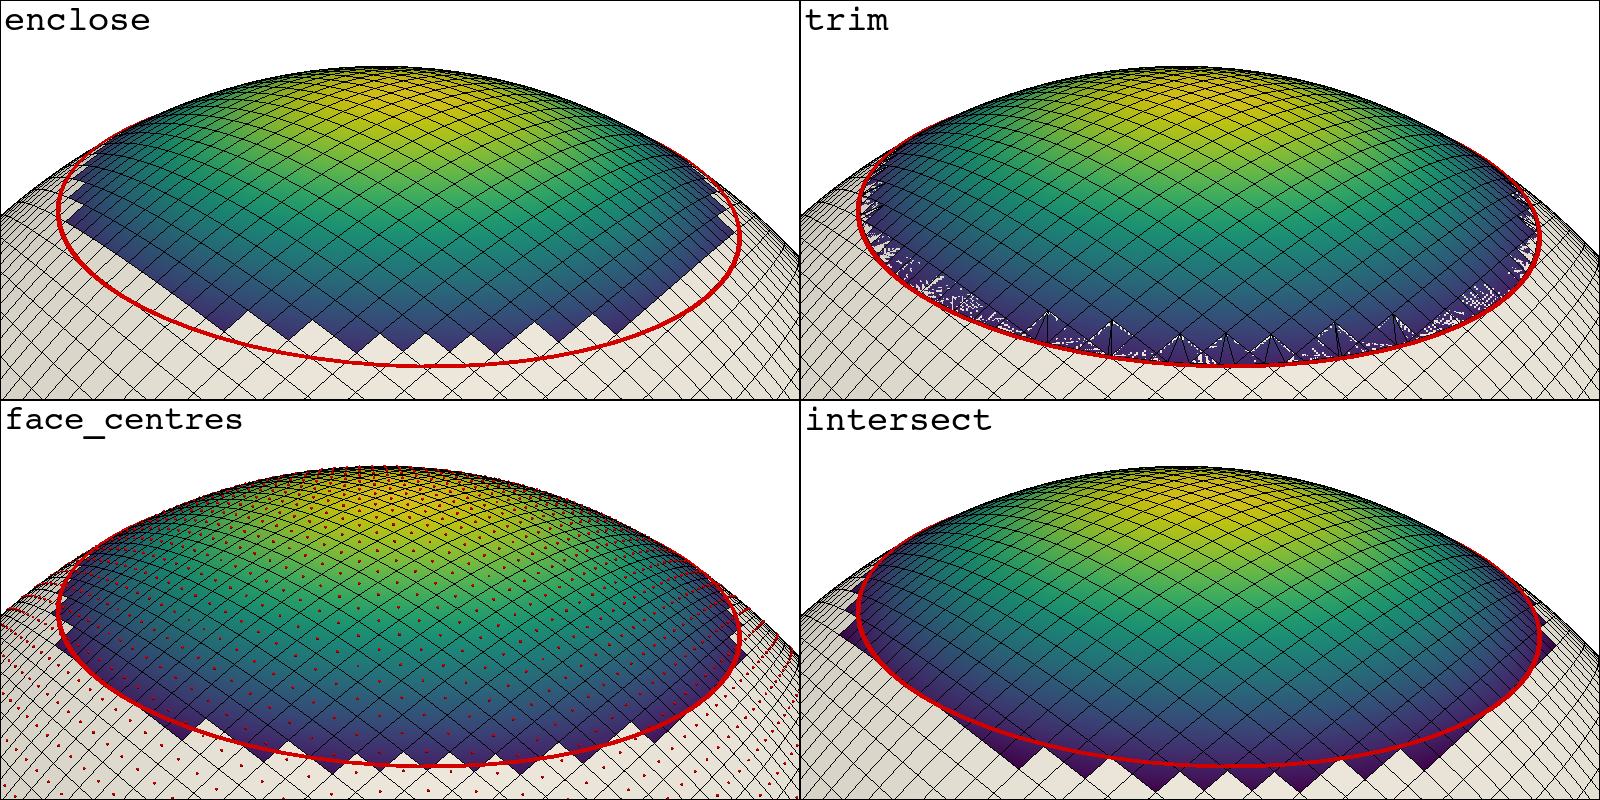

In [9]:
# Plot
p = pv.Plotter(shape=(2,2))

# Enclose
p.add_mesh(mesh, color='white', show_edges='True')
p.add_mesh(mesh_enclose, show_edges='black')
p.add_mesh(disc, color='red')
p.add_text("enclose", font_size=15, color='black', font="courier")

# Trim
p.subplot(0,1)
p.add_mesh(mesh, style='wireframe', color='black')
p.add_mesh(mesh, color='white', show_edges='black')
p.add_mesh(mesh_trim, show_edges='black')
p.add_mesh(disc, color='red')
p.add_text("trim", font_size=15, color='black', font="courier")

# Face Centres
p.subplot(1,0)
p.add_mesh(mesh, color='white', show_edges='True')
p.add_mesh(mesh_face_centre, show_edges='black')
p.add_mesh(disc, color='red')
p.add_mesh(mesh_cc, color="r", point_size=3.0, render_points_as_spheres=True)
p.add_text("face_centres", font_size=15, color='black', font="courier")

# "intersect" 
p.subplot(1,1)
p.add_mesh(mesh, color='white', show_edges='True')
p.add_mesh(mesh_intersect, show_edges='black')
p.add_mesh(disc, color='red')
p.add_text("intersect", font_size=15, color='black', font="courier")

p.background_color='white'
p.remove_scalar_bar()
p.link_views()
p.camera_position = [(0.8307707232931513, 0.7229574741766207, 1.3222145497854225),
 (5.551115123125783e-17, -8.951115123125783e-17, 0.81330127018922193),
 (-0.25020383488700676, -0.25531534306956494, 0.4939229714495226)]
           
p.show(screenshot='compare_extract.png', window_size=(1600, 800))